
# LSTM — Funcionamento Básico

Este notebook demonstra **passo a passo** o funcionamento de uma **LSTM (Long Short-Term Memory)**,
fazendo o mapeamento do **diagrama conceitual** (com *forget gate*, *input gate* e *output gate*) para as **equações** e para uma **implementação prática** em PyTorch.

> Objetivos
> 1. Revisar a **motivação** e o **fluxo** da LSTM a partir do diagrama.
> 2. Ver as **equações** que correspondem às portas e estados (*cell state* `c_t` e *hidden state* `h_t`).
> 3. Implementar **uma LSTM *from scratch* (uma célula)** para inspecionar os valores das portas.
> 4. Comparar com a **`nn.LSTM`** do PyTorch.
> 5. (Opcional) **Treinar rapidamente** uma LSTM em uma série temporal simples (seno).

---



## Diagrama de Referência (Portas da LSTM)

A figura abaixo ilustra as **portas** e o **fluxo de informações** em uma LSTM:
- **Forget gate** decide o que **esquecer** do estado de célula anterior `c_{t-1}`.
- **Input gate** decide **quanto** de nova informação **entrará** em `c_t` (com uma componente candidata).
- **Output gate** decide **quanto** do estado de célula será **exposto** no `h_t`.

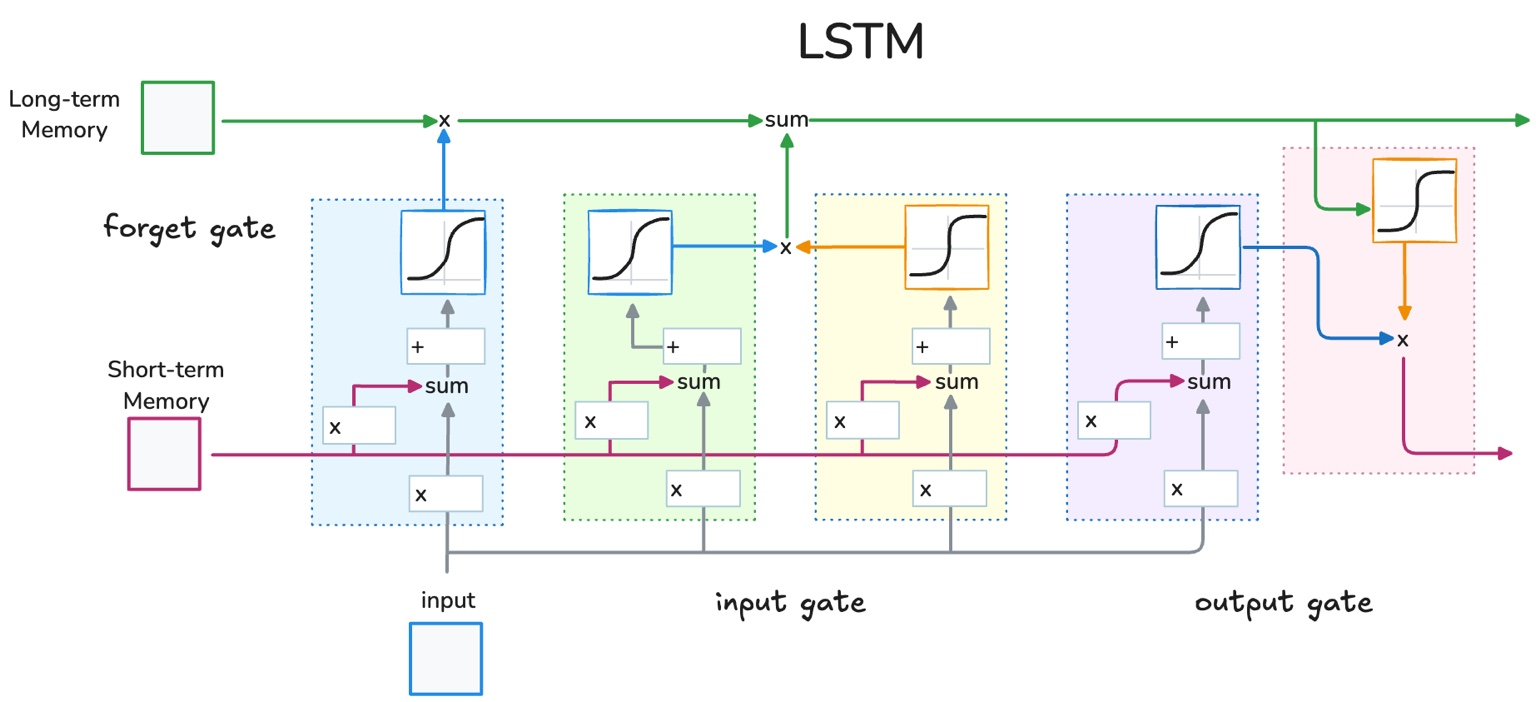



## Equações que Correspondem ao Diagrama

Para um vetor de entrada $x_t$, um estado oculto anterior $h_{t-1}$ e um estado de célula anterior $c_{t-1}$,
uma célula LSTM computa (com pesos e vieses $W*$ e $b*$):

\begin{align}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) && \text{(forget gate)} \\
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) && \text{(input gate)} \\
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) && \text{(candidata a novo conteúdo)} \\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t && \text{(novo estado de célula)} \\
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) && \text{(output gate)} \\
h_t &= o_t \odot \tanh(c_t) && \text{(novo estado oculto)}
\end{align}

- `σ` é a **sigmóide**; $tanh$ é a **hiperbólica**.
- `⊙` indica **produto elemento a elemento**.
- O **esquecimento** atua diretamente sobre o **$c_{t-1}$**; a **entrada** controla a **porção da candidata** que será incorporada; a **saída** controla o **quanto de $c_t$ passa para $h_t$**.

---



## Implementação de uma Célula LSTM *From Scratch* (PyTorch)

Aqui implementamos **uma única célula** LSTM para **inspecionar os valores das portas** e
relacioná-los ao diagrama. A implementação segue as equações acima.


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(7)

class LSTMCellFromScratch(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Pesos conjuntos para [x_t, h_{t-1}]
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        # Concatena entrada e hidden anterior
        concat = torch.cat([x_t, h_prev], dim=-1)

        f_t = torch.sigmoid(self.W_f(concat))       # forget gate
        i_t = torch.sigmoid(self.W_i(concat))       # input gate
        c_tilde = torch.tanh(self.W_c(concat))      # candidata
        c_t = f_t * c_prev + i_t * c_tilde          # novo cell state
        o_t = torch.sigmoid(self.W_o(concat))       # output gate
        h_t = o_t * torch.tanh(c_t)                 # novo hidden

        # Retorna também as portas para inspeção
        return h_t, c_t, {'f_t': f_t, 'i_t': i_t, 'o_t': o_t, 'c_tilde': c_tilde}

# Exemplo simples: sequência de 4 vetores (batch=1, input_size=3)
input_size = 3
hidden_size = 5
cell = LSTMCellFromScratch(input_size, hidden_size)

# Estados iniciais h0 e c0
h = torch.zeros(1, hidden_size)
c = torch.zeros(1, hidden_size)

# Sequência fictícia (poderia ser embeddings de tokens)
x_seq = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.5, 0.5, 0.0],
]).unsqueeze(1)  # shape: (T, 1, 3) -> usaremos passo a passo

# Executa passo a passo e coleta as portas
gate_history = {'f': [], 'i': [], 'o': []}
for t in range(x_seq.shape[0]):
    x_t = x_seq[t]  # (1, 3)
    h, c, gates = cell(x_t, h, c)
    gate_history['f'].append(gates['f_t'].detach().numpy().ravel())
    gate_history['i'].append(gates['i_t'].detach().numpy().ravel())
    gate_history['o'].append(gates['o_t'].detach().numpy().ravel())

print("Shapes -> h:", h.shape, " c:", c.shape)
print("Exemplo de valores finais (h[-1]):", h.detach().numpy().ravel()[:5])



### Visualizando a dinâmica das portas ao longo do tempo

Abaixo, fazemos um gráfico simples (sem especificar cores) para observar as **médias** das ativações das portas `f`, `i` e `o` em cada passo temporal.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

f_mean = [np.mean(v) for v in gate_history['f']]
i_mean = [np.mean(v) for v in gate_history['i']]
o_mean = [np.mean(v) for v in gate_history['o']]

plt.figure()
plt.plot(f_mean, label='forget (média)')
plt.plot(i_mean, label='input (média)')
plt.plot(o_mean, label='output (média)')
plt.xlabel("passo t")
plt.ylabel("ativação média")
plt.legend()
plt.title("Ativações médias das portas ao longo do tempo")
plt.show()



## Comparando com `nn.LSTM` (PyTorch)

Nesta seção, executamos uma **LSTM real** (`nn.LSTM`) em uma sequência simples para mostrar:
- Como empacotar dados no formato `(seq_len, batch, input_size)`.
- Como obter $output$ (todos os $h_t$) e o par $(h_n, c_n)$ finais.


In [ ]:

import torch

torch.manual_seed(7)

seq_len, batch, input_size = 6, 1, 4
hidden_size = 8

# Sequência aleatória
x = torch.randn(seq_len, batch, input_size)

lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=False)
output, (h_n, c_n) = lstm(x)

print("output shape (todos h_t):", output.shape)  # (seq_len, batch, hidden_size)
print("h_n shape (último hidden):", h_n.shape)    # (num_layers, batch, hidden_size)
print("c_n shape (último cell):", c_n.shape)      # (num_layers, batch, hidden_size)



## Mini-treinamento: prever seno(t) com LSTM (Opcional)

Treinamos rapidamente uma LSTM pequena para prever $y_{t+1}$ a partir de uma janela de tamanho `T` da função seno.
Isso ilustra a capacidade da LSTM de **capturar dependências temporais** e **generalizar** padrões simples.

> Observação: o objetivo é didático — poucas épocas, rede pequena.


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# Gera dados seno
T = 20           # tamanho da janela
N = 200          # número de pontos
x_vals = np.linspace(0, 12*math.pi, N, dtype=np.float32)
y_vals = np.sin(x_vals)

# Cria janelas (X) e próximo valor (y)
X = []
y = []
for i in range(N - T - 1):
    X.append(y_vals[i:i+T])
    y.append(y_vals[i+T])
X = np.array(X, dtype=np.float32)        # (N-T-1, T)
y = np.array(y, dtype=np.float32)        # (N-T-1,)

# Divide treino/teste
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Converte para tensores LSTM (seq_len, batch, input_size)
def to_seq(x_np):
    # input_size=1
    return torch.from_numpy(x_np).unsqueeze(-1).transpose(0,1).transpose(0,2)
    # Explicação: começamos com (batch, T) -> (batch, T, 1) -> (T, batch, 1)

X_train_t = to_seq(X_train)
y_train_t = torch.from_numpy(y_train).unsqueeze(0).unsqueeze(-1)  # (1, batch, 1) para combinar com saída final
X_test_t  = to_seq(X_test)
y_test_t  = torch.from_numpy(y_test).unsqueeze(0).unsqueeze(-1)

# Modelo LSTM simples
class TinyLSTM(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, (h, c) = self.lstm(x)  # out: (T, batch, hidden)
        yhat = self.fc(out[-1])     # usa último hidden
        return yhat

model = TinyLSTM(hidden_size=16)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 200
for ep in range(epochs):
    model.train()
    opt.zero_grad()
    yhat = model(X_train_t)
    loss = loss_fn(yhat, y_train_t)
    loss.backward()
    opt.step()

# Avaliação e plot
model.eval()
with torch.no_grad():
    yhat_test = model(X_test_t).squeeze().numpy()

plt.figure()
plt.plot(y_test, label="verdadeiro")
plt.plot(yhat_test, label="predito")
plt.title("Previsão de seno com LSTM (janela T)")
plt.xlabel("amostras de teste")
plt.ylabel("valor")
plt.legend()
plt.show()



## Conclusões e Conexão com o Diagrama

- O **esquecimento** atua multiplicando $c_{t-1}$ por $f_t$ (portas próximas à linha verde no diagrama).
- A **entrada** controla a **fração** da candidata $\tilde{c}_t$ que entra em $c_t$ via $i_t$.
- A **saída** controla quanto do $c_t$ passa para $h_t$ via $o_t$.
- Ao inspecionar as **portas ao longo do tempo**, vemos como a LSTM **seleciona** o que manter, incorporar e expor — exatamente o que o diagrama ilustra.

> Próximos passos: experimentar **máscaras/padding** para tamanhos de sequência variáveis, ou comparar **GRU** vs **LSTM** no mesmo conjunto.
